# MARATONA BEHIND THE CODE 2020

## DESAFIO 7: TNT

## Testes com modelo Deep Learning (MLP)
- Autor: Rodrigo Lima
- LinkedIN: https://www.linkedin.com/in/rodrigolima82/


![title](tnt_image.jpg)

# Parte 01. Importando as bibliotecas

In [1]:
# Pacotes padrao
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# Pacote do sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pacote de Deep Learning
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.models import load_model

# Pacote para balanceamento dos dados
from imblearn.over_sampling import SMOTE

# Desativando warnings no jupyter
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Parte 02. Carregando o dataset de treino

In [2]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL
treino = pd.read_csv(r'train_17015.csv')
print('Quantidade de registros e colunas: ',treino.shape)
treino.head()

Quantidade de registros e colunas:  (17015, 15)


,Tempo,Estacao,LAT,LONG,Movimentacao,Original_473,Original_269,Zero,Maca_Verde,Tangerina,Citrus,Acai_Guarana,Pessego,TARGET,row
0,2019-12-30,Fradique Coutinho,-23.5661,-46.6841,35386,24,45,61,42,19,22,15,9,NORMAL,10800
1,2018-01-08,Luz,-23.5365,-46.6332,124806,15,10,10,29,10,25,14,13,NORMAL,10808
2,2018-04-17,Luz,-23.5365,-46.6332,125215,53,1,55,18,18,6,37,8,REABASTECER,10907
3,2018-07-18,Luz,-23.5365,-46.6332,126476,36,5,57,38,15,43,43,18,REABASTECER,10998
4,2018-08-28,Luz,-23.5365,-46.6332,125917,79,10,8,37,32,30,18,15,NORMAL,11038


In [3]:
# Visualizando o tipo dos dados
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17015 entries, 0 to 17014
Data columns (total 15 columns):
Tempo           16921 non-null object
Estacao         17015 non-null object
LAT             17015 non-null float64
LONG            17015 non-null float64
Movimentacao    17015 non-null int64
Original_473    17015 non-null int64
Original_269    17015 non-null int64
Zero            17015 non-null int64
Maca_Verde      17015 non-null int64
Tangerina       17015 non-null int64
Citrus          17015 non-null int64
Acai_Guarana    17015 non-null int64
Pessego         17015 non-null int64
TARGET          17015 non-null object
row             17015 non-null int64
dtypes: float64(2), int64(10), object(3)
memory usage: 1.9+ MB


,TARGET,%
NORMAL,11517,67.687
REABASTECER,5498,32.313


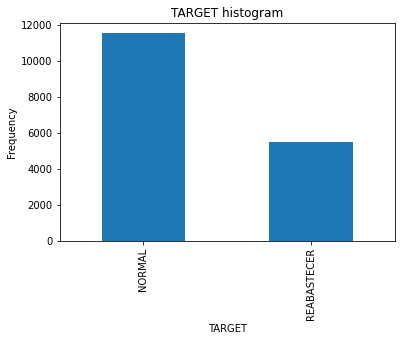

In [4]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(treino['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(treino['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

# Parte 03. Feature Engineering

In [5]:
# Removendo colunas que não serão utilizadas no treinamento
treino = treino.drop(['Tempo','Estacao','Movimentacao','LAT','LONG', 'row'], axis = 1)

# Converte colunas para numerico
treino = treino.apply(pd.to_numeric, errors='ignore')

# Visualizando os primeiros registros
treino.head()

,Original_473,Original_269,Zero,Maca_Verde,Tangerina,Citrus,Acai_Guarana,Pessego,TARGET
0,24,45,61,42,19,22,15,9,NORMAL
1,15,10,10,29,10,25,14,13,NORMAL
2,53,1,55,18,18,6,37,8,REABASTECER
3,36,5,57,38,15,43,43,18,REABASTECER
4,79,10,8,37,32,30,18,15,NORMAL


# Parte 04. Modelagem Preditiva
> - Nesta fase estarei construindo os modelos preditivos
> - Vou utilizar Deep Learning para o treinamento

In [6]:
# Definindo métricas
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
# Definindo alguns parametros
EPOCH = 1000
SEED  = 42

In [8]:
# Selecionando features para treinamento
X = treino.drop(['TARGET'], axis = 1)

# Selecionando feature target
y = treino['TARGET']

# Transformando target em tipo numerico
y = y.astype("category").cat.codes

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X = StandardScaler().fit_transform(X)

# Split dos dados
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = .2, random_state = SEED, stratify = y)

### Sem Balanceamento dos dados

In [9]:
# Cria o modelo
modelo_dl = Sequential()

In [10]:
# Adiciona as camadas ocultas
modelo_dl.add(Dense(units = 26, kernel_initializer = 'uniform', activation = 'relu', input_dim = 8))
modelo_dl.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
modelo_dl.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
modelo_dl.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
modelo_dl.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [11]:
# Compila o modelo
modelo_dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [12]:
modelo_dl.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 26)                234       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1728      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 10,347
Trainable params: 10,347
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Treinamento do modelo
modelo_dl.fit(X_treino, y_treino, 
              validation_data=(X_teste, y_teste), 
              epochs=EPOCH, 
              verbose=1, 
              shuffle=True, 
              callbacks=[es])

Train on 13612 samples, validate on 3403 samples
Epoch 1/1000
13612/13612 [==============================] - 1s 106us/step - loss: 0.6015 - acc: 0.6761 - f1_m: 0.0010 - precision_m: 6.9553e-04 - recall_m: 0.0019 - val_loss: 0.5770 - val_acc: 0.6768 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/1000
13612/13612 [==============================] - 1s 53us/step - loss: 0.5817 - acc: 0.6769 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.5657 - val_acc: 0.6768 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/1000
13612/13612 [==============================] - 1s 46us/step - loss: 0.5665 - acc: 0.6784 - f1_m: 0.1329 - precision_m: 0.1879 - recall_m: 0.1159 - val_loss: 0.5555 - val_acc: 0.6888 - val_f1_m: 0.4388 - val_precision_m: 0.5195 - val_recall_m: 0.3970
Epoch 4/1000
13612/13612 [==============================] - 1s 52us/step - loss: 0.5508 - acc: 0.6943 - f1_m: 0.4208 - pr

Epoch 32/1000
13612/13612 [==============================] - 1s 47us/step - loss: 0.4015 - acc: 0.7704 - f1_m: 0.7041 - precision_m: 0.5993 - recall_m: 0.8805 - val_loss: 0.4135 - val_acc: 0.7652 - val_f1_m: 0.6731 - val_precision_m: 0.6049 - val_recall_m: 0.7795
Epoch 33/1000
13612/13612 [==============================] - 1s 46us/step - loss: 0.3984 - acc: 0.7721 - f1_m: 0.7055 - precision_m: 0.6007 - recall_m: 0.8833 - val_loss: 0.4117 - val_acc: 0.7676 - val_f1_m: 0.6898 - val_precision_m: 0.5988 - val_recall_m: 0.8322
Epoch 34/1000
13612/13612 [==============================] - 1s 47us/step - loss: 0.3996 - acc: 0.7722 - f1_m: 0.7029 - precision_m: 0.5978 - recall_m: 0.8770 - val_loss: 0.3933 - val_acc: 0.7764 - val_f1_m: 0.7102 - val_precision_m: 0.6070 - val_recall_m: 0.8766
Epoch 35/1000
13612/13612 [==============================] - 1s 49us/step - loss: 0.3999 - acc: 0.7705 - f1_m: 0.7028 - precision_m: 0.5972 - recall_m: 0.8807 - val_loss: 0.4147 - val_acc: 0.7629 - val_f1_m: 

In [14]:
# validação do modelo em Treino
loss, accuracy, f1_score, precision, recall = modelo_dl.evaluate(X_treino, y_treino, verbose=0)
print('Treino - ACC %.3f, F1 %.3f' % (accuracy, f1_score))

# validação do modelo em Teste
loss, accuracy, f1_score, precision, recall = modelo_dl.evaluate(X_teste, y_teste, verbose=0)
print('Teste - ACC %.3f, F1 %.3f' % (accuracy, f1_score))

Treino - ACC 0.781, F1 0.721
Teste - ACC 0.770, F1 0.702


In [15]:
# Realizando as previsões com dados de teste
y_pred_probs   = modelo_dl.predict(X_teste, verbose=0)

# Converte as probabilidades em classe
y_pred_probs = (y_pred_probs > 0.5)

# Agora convertemos os valores booleanos em classe binária, 0 ou 1
y_pred_probs = np.where(y_pred_probs == 'True', 1, y_pred_probs)

In [16]:
# Cria e imprime a matriz de confusão
conf_matriz_dl = confusion_matrix(y_teste, y_pred_probs)
print(conf_matriz_dl)

# Calcula o total 
total1 = sum(sum(conf_matriz_dl))

# Calcula a acurácia
accuracy_dl = (conf_matriz_dl[0,0] + conf_matriz_dl[1,1]) / total1
    
# Calcula especificidade e sensibilidade
speci_dl = conf_matriz_dl[0,0] / (conf_matriz_dl[0,0] + conf_matriz_dl[0,1])
sensi_dl = conf_matriz_dl[1,1] / (conf_matriz_dl[1,0] + conf_matriz_dl[1,1])

# Print
print('\nAcurácia : ', accuracy_dl)
print('Sensibilidade :', sensi_dl)
print('Especificidade :', speci_dl)

[[1664  639]
 [ 144  956]]

Acurácia :  0.7699089039083162
Sensibilidade : 0.8690909090909091
Especificidade : 0.7225358228397742


In [17]:
# Relatório de Classificação
print(classification_report(y_teste, y_pred_probs))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      2303
           1       0.60      0.87      0.71      1100

    accuracy                           0.77      3403
   macro avg       0.76      0.80      0.76      3403
weighted avg       0.82      0.77      0.78      3403



### Com Balanceamento dos dados

In [18]:
# Aplicando a funcao SMOTE
sm = SMOTE(random_state=0)
X_treino_bal, y_treino_bal = sm.fit_sample(X_treino, y_treino)

In [19]:
# Cria o modelo
modelo_dl_bal = Sequential()

# Adiciona as camadas ocultas
modelo_dl_bal.add(Dense(units = 26, kernel_initializer = 'uniform', activation = 'relu', input_dim = 8))
modelo_dl_bal.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
modelo_dl_bal.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
modelo_dl_bal.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
modelo_dl_bal.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compila o modelo
modelo_dl_bal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Treinamento do modelo
modelo_dl_bal.fit(X_treino_bal, y_treino_bal, validation_data=(X_teste, y_teste), epochs=EPOCH, verbose=1, shuffle=True, callbacks=[es])

Train on 18428 samples, validate on 3403 samples
Epoch 1/1000
18428/18428 [==============================] - 1s 62us/step - loss: 0.6465 - acc: 0.6148 - f1_m: 0.6551 - precision_m: 0.5971 - recall_m: 0.7578 - val_loss: 0.6062 - val_acc: 0.6330 - val_f1_m: 0.5725 - val_precision_m: 0.4621 - val_recall_m: 0.7866
Epoch 2/1000
18428/18428 [==============================] - 1s 45us/step - loss: 0.5906 - acc: 0.6792 - f1_m: 0.7054 - precision_m: 0.6468 - recall_m: 0.7953 - val_loss: 0.5561 - val_acc: 0.6624 - val_f1_m: 0.5909 - val_precision_m: 0.4876 - val_recall_m: 0.7814
Epoch 3/1000
18428/18428 [==============================] - 1s 45us/step - loss: 0.5641 - acc: 0.6958 - f1_m: 0.7291 - precision_m: 0.6523 - recall_m: 0.8434 - val_loss: 0.5485 - val_acc: 0.6665 - val_f1_m: 0.6057 - val_precision_m: 0.4915 - val_recall_m: 0.8223
Epoch 4/1000
18428/18428 [==============================] - 1s 45us/step - loss: 0.5448 - acc: 0.7104 - f1_m: 0.7411 - precision_m: 0.6656 - recall_m: 0.8518 - va

In [20]:
# validação do modelo em Treino
loss, accuracy, f1_score, precision, recall = modelo_dl_bal.evaluate(X_treino_bal, y_treino_bal, verbose=0)
print('Treino - ACC %.3f, F1 %.3f' % (accuracy, f1_score))

# validação do modelo em Teste
loss, accuracy, f1_score, precision, recall = modelo_dl_bal.evaluate(X_teste, y_teste, verbose=0)
print('Teste - ACC %.3f, F1 %.3f' % (accuracy, f1_score))

Treino - ACC 0.818, F1 0.790
Teste - ACC 0.768, F1 0.717


In [21]:
# Realizando as previsões com dados de teste
y_pred_probs   = modelo_dl_bal.predict(X_teste, verbose=0)

# Converte as probabilidades em classe
y_pred_probs = (y_pred_probs > 0.5)

# Agora convertemos os valores booleanos em classe binária, 0 ou 1
y_pred_probs = np.where(y_pred_probs == 'True', 1, y_pred_probs)

In [22]:
# Cria e imprime a matriz de confusão
conf_matriz_dl = confusion_matrix(y_teste, y_pred_probs)
print(conf_matriz_dl)

# Calcula o total 
total1 = sum(sum(conf_matriz_dl))

# Calcula a acurácia
accuracy_dl = (conf_matriz_dl[0,0] + conf_matriz_dl[1,1]) / total1
    
# Calcula especificidade e sensibilidade
speci_dl = conf_matriz_dl[0,0] / (conf_matriz_dl[0,0] + conf_matriz_dl[0,1])
sensi_dl = conf_matriz_dl[1,1] / (conf_matriz_dl[1,0] + conf_matriz_dl[1,1])

# Print
print('\nAcurácia : ', accuracy_dl)
print('Sensibilidade :', sensi_dl)
print('Especificidade :', speci_dl)

[[1586  717]
 [  72 1028]]

Acurácia :  0.7681457537466941
Sensibilidade : 0.9345454545454546
Especificidade : 0.6886669561441597


In [23]:
# Relatório de Classificação
print(classification_report(y_teste, y_pred_probs))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80      2303
           1       0.59      0.93      0.72      1100

    accuracy                           0.77      3403
   macro avg       0.77      0.81      0.76      3403
weighted avg       0.84      0.77      0.78      3403



# Parte 05. Realizando novas previsões

In [24]:
# Carregando o dataset de testes 
teste  = pd.read_csv(r'to_be_scored.csv')
print('Quantidade de registros e colunas: ',teste.shape)

# Removendo colunas que não serão utilizadas no treinamento
teste = teste.drop(['Tempo','Estação','Movimentação','LAT','LONG'], axis = 1)

# Visualizando os primeiros registros
teste.head()

Quantidade de registros e colunas:  (984, 13)


,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego
0,22,65,22,14,3,26,43,18
1,11,56,16,14,43,20,37,15
2,86,51,8,11,41,20,35,12
3,76,47,65,11,37,14,32,10
4,68,42,60,6,35,13,26,5


In [25]:
# Padronizando os dados (0 para a média, 1 para o desvio padrão)
teste_scaler = StandardScaler().fit_transform(teste)

# Realizando previsoes com dados de teste(usando modelo NAO BALANCEADO)
y_pred_test = modelo_dl.predict(teste_scaler)

# Converte as probabilidades em classe
y_pred_test = (y_pred_test > 0.5)

# Agora convertemos os valores booleanos em classe binária, 0 ou 1
y_pred_test = np.where(y_pred_test == 'True', 1, y_pred_test)

In [26]:
# Salvando na coluna target
teste['TARGET'] = y_pred_test
teste['TARGET'] = np.where(teste['TARGET'] == 0, 'NORMAL', 'REABASTECER')

# Visualizando os ultimos registros
teste.tail()

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
979,34,65,28,17,33,27,6,2,REABASTECER
980,21,60,18,15,27,22,43,43,NORMAL
981,9,56,13,14,21,17,37,37,REABASTECER
982,86,49,7,14,17,12,33,33,REABASTECER
983,74,41,65,8,14,7,27,27,NORMAL


,TARGET,%
NORMAL,509,51.728
REABASTECER,475,48.272


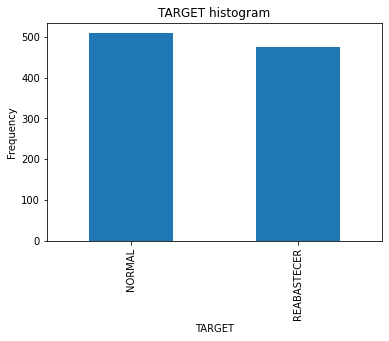

In [27]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(teste['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(teste['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

In [28]:
# Gravando resultado em csv
teste.to_csv('results_mlp.csv',index=False)